In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import preps, opts, params, feats, strats
importlib.reload(preps)
importlib.reload(opts)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strats)

<module 'libs.strats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/strats.py'>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.samplers import TPESampler
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

from datetime import time
import json
import re
from re import findall

from IPython.display import display, clear_output, update_display, HTML
import io
import os
import json
import contextlib
from tqdm import tqdm

pd.set_option('display.max_columns', None)


,open,high,low,close,volume,trade_count,vwap,ask,bid,rsi_6,atr_14,adx_14,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,97.117392,0.053679,19.072892,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,97.117392,0.049844,23.632803,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,94.266696,0.046998,27.633299,152.307813
2021-09-01 08:03:00,152.290,152.290,152.290,152.290,637.0,53.0,152.290000,152.3205,152.2595,91.059251,0.044356,31.105532,152.305425
2021-09-01 08:04:00,152.310,152.310,152.290,152.290,582.0,20.0,152.298281,152.3205,152.2595,91.059251,0.042616,34.396121,152.303742
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 23:55:00,146.925,146.925,146.925,146.925,420.0,15.5,146.925000,146.9544,146.8956,41.862048,0.031785,20.469780,147.712166
2023-02-28 23:56:00,146.890,146.890,146.890,146.890,296.0,14.0,146.890000,146.9194,146.8606,33.559533,0.032014,20.411414,147.712162
2023-02-28 23:57:00,146.910,146.910,146.910,146.910,326.0,20.0,146.910000,146.9394,146.8806,41.513568,0.031156,19.854952,147.712158
2023-02-28 23:58:00,146.900,146.920,146.900,146.900,7297.0,29.0,146.900371,146.9294,146.8706,38.731484,0.030359,19.338237,147.712062


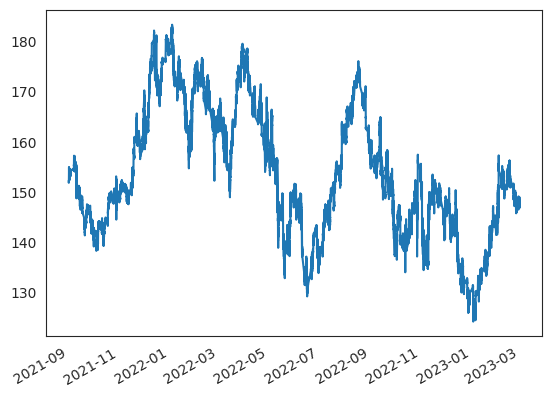

In [3]:
# loading csv with indicators unscaled

hdr = pd.read_csv(params.indunsc_csv, nrows=0).columns.tolist()
index_name = hdr[0]   # first column header, whatever it is

cols_needed = [
    "open","high","low","close","volume","trade_count","vwap","ask","bid",
    params.col_atr_tick, params.col_adx_tick, params.col_rsi_tick, params.col_vwap_tick,
]

usecols = [index_name] + cols_needed

df_inds = pd.read_csv(params.indunsc_csv, usecols=usecols, index_col=index_name, parse_dates=True)
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################
df_inds.close.plot()
df_inds

In [4]:
# {'min_prof_thr': (-0.00034365146956263524, 0.004533651469562635),
#  'max_down_prop': (0.0010489207251797705, 0.005691079274820229),
#  'gain_tightfact': (0.030141284057250493, 0.0667987159427495),
#  'tau_time': (8.484544524826685, 8.549365475173314),
#  'tau_dur': (5.496227995880168, 5.970092004119832),
#  'thresh_mode': {'categorical': ['median_nonzero']},
#  'reset_peak': (0, 0),
#  'rsi_min_thresh': (-2, 2),
#  'rsi_max_thresh': (69, 97),
#  'adx_thresh': (5.102404140324963, 7.535145859675038),
#  'atr_mult': (0.14781632428439967, 0.15584367571560037),
#  'vwap_atr_mult': (-2.48044530245896, -0.9269146975410395),
#  'buy_factor': (0.0009926904941714334, 0.006347309505828567),
#  'sell_factor': (-0.006708966092696439, 0.012178966092696438),
#  'trailstop_pct': (15.412656700442179, 40.878093299557825)}

{'min_prof_thr': (-0.00034365146956263524, 0.004533651469562635),
 'max_down_prop': (0.0010489207251797705, 0.005691079274820229),
 'gain_tightfact': (0.030141284057250493, 0.0667987159427495),
 'tau_time': (8.484544524826685, 8.549365475173314),
 'tau_dur': (5.496227995880168, 5.970092004119832),
 'thresh_mode': {'categorical': ['median_nonzero']},
 'reset_peak': (0, 0),
 'rsi_min_thresh': (-2, 2),
 'rsi_max_thresh': (69, 97),
 'adx_thresh': (5.102404140324963, 7.535145859675038),
 'atr_mult': (0.14781632428439967, 0.15584367571560037),
 'vwap_atr_mult': (-2.48044530245896, -0.9269146975410395),
 'buy_factor': (0.0009926904941714334, 0.006347309505828567),
 'sell_factor': (-0.006708966092696439, 0.012178966092696438),
 'trailstop_pct': (15.412656700442179, 40.878093299557825)}

In [5]:
prun_perc       = 80
report_interval = 50

def objective(trial: optuna.Trial) -> float:
    
    min_prof_thr    = trial.suggest_float("min_prof_thr", 0.001, 0.01)      # median ~0.12
    max_down_prop   = trial.suggest_float("max_down_prop", 0.001, 0.007)     # median ~0.12
    gain_tightfact  = trial.suggest_float("gain_tightfact", 0.03, 0.07)   # median ~0.033
    tau_time        = trial.suggest_float("tau_time", 8.3, 8.7)          # median ~25.4 (narrow)
    tau_dur         = trial.suggest_float("tau_dur", 5.3, 6.2)          # median ~45, allow wider spread
    
    thresh_mode     = trial.suggest_categorical("thresh_mode",
                           ["median_nonzero"])
    thresh_window   = (trial.suggest_int("thresh_window", 10, 100)
                       if "roll" in thresh_mode else None)
    
    reset_peak     = trial.suggest_categorical("reset_peak", [False])
    rsi_min_thresh = trial.suggest_int("rsi_min_thresh", 0, 5)            # median ~9
    rsi_max_thresh = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 70), 100)          # median ~89
    adx_thresh     = trial.suggest_float("adx_thresh", 5, 8)          # median ~10.5
    atr_mult       = trial.suggest_float("atr_mult", 0.12, 0.18)             # median ~1.4–1.6
    vwap_atr_mult  = trial.suggest_float("vwap_atr_mult", -3, -1)       # many good trials negative; allow some positive
    buy_factor     = trial.suggest_float("buy_factor", 0.001, 0.007)         # median ~0.45
    sell_factor    = trial.suggest_float("sell_factor", 0.0005, 0.015)        # median ~0.05–0.10
    trailstop_pct  = trial.suggest_float("trailstop_pct", 10, 40)        # median ~3.0

    print("-" * 160)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    # Build signals for this trial
    df = preps.build_signal_per_day(
        df              = df_inds.copy(),
        min_prof_thr    = min_prof_thr,
        max_down_prop   = max_down_prop,
        gain_tightfact  = gain_tightfact,
        tau_time        = tau_time,
        tau_dur         = tau_dur,
        thresh_mode     = thresh_mode,
        thresh_window   = thresh_window,
    )

    # Group per-day for this trial
    groups_list = list(df.groupby(df.index.normalize()))

    # Reset globals
    start_ask = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)

    daily_pnls, daily_bh_pnls = [], []
    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}

    pbar = tqdm(groups_list, desc=f"Trial {trial.number}", leave=True)
    for step, (day, df_day) in enumerate(pbar, 1):
        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_signal      = "signal_raw",
            sign_thresh     = "signal_thresh",
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
        )

        sim_results = strats.simulate_trading(
            day         = day,
            df          = df_actions,
            buy_factor  = buy_factor,
            sell_factor = sell_factor,
        )

        df_sim, trades, stats = next(iter(sim_results.values()))

        trial_action_counts["Buy"]  += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        daily_pnls.append(strats._parse_eq_value(stats["STRATEGY"]))
        daily_bh_pnls.append(strats._parse_eq_value(stats["BUYNHOLD"]))

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))

            trial.set_user_attr("mean_pnl",      float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls",  float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})

            trial.report(prun_val, report_step)
            if trial.should_prune():
                vals = [
                    t.intermediate_values[report_step]
                    for t in trial.study.get_trials(deepcopy=False)
                    if t.state == TrialState.COMPLETE and report_step in t.intermediate_values
                ]
                thr = np.percentile(vals, prun_perc) if vals else prun_val
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    trial.set_user_attr("mean_pnl",     float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts",{k: int(v) for k, v in trial_action_counts.items()})

    mean_excess = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))
    return mean_excess



Baseline mean daily B&H: -9.5162


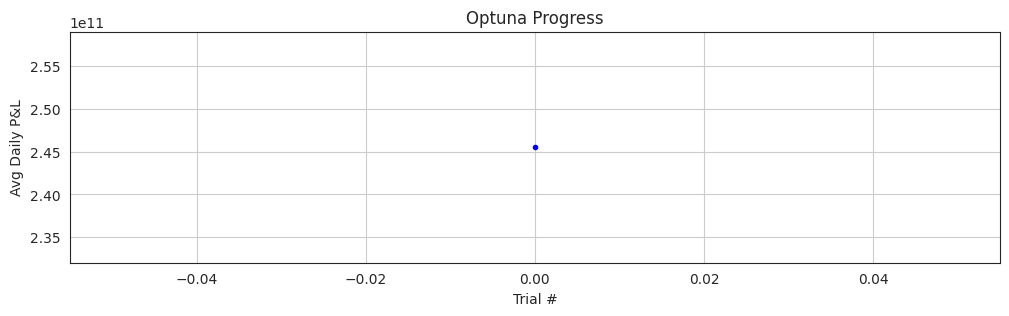

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.004130634033285234; max_down_prop=0.0029253956923388762; gain_tightfact=0.046670611573427105; tau_time=8.338256891272971; tau_dur=5.944014217614677; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=97; adx_thresh=6.682922581116241; atr_mult=0.1421018138659405; vwap_atr_mult=-2.4365752046307656; buy_factor=0.002235584285964521; sell_factor=0.010983624575393465; trailstop_pct=11.663608838285244


Trial 0: 100%|██████████| 375/375 [01:59<00:00,  3.14it/s]


[Results] mean_pnl:245519743100.5704 mean_bh:-8.7491 mean_excess:245519743109.3196 improv_vs_bh:2806231555523.03%
Action counts: {'Buy': 43104, 'Sell': 39174, 'Hold': 268433}
Best trial is: 0 with best_val: 245519743109.3196
[save_results] wrote optuna_results/AAPL_245519743109.3196_target.csv
[save_best_json] wrote optuna_results/AAPL_245519743109.3196_target.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00559246204740074; max_down_prop=0.0030811141113135; gain_tightfact=0.041544360508642846; tau_time=8.533522478152245; tau_dur=6.062356982448522; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=73; adx_thresh=5.654465131424002; atr_mult=0.15199771252798533; vwap_atr_mult=-2.0296887066673843; buy_factor=0.006601565049267647; sell_factor=0.010163630345383368; trailstop_pct=25.904413038103094


Trial 1:  79%|███████▉  | 297/375 [01:11<00:41,  1.89it/s]

In [ ]:
importlib.reload(opts) ########
# Warmup steps computed once from base data
base_groups        = list(df_inds.groupby(df_inds.index.normalize()))
total_days_base    = len(base_groups)
reports_per_trial  = math.ceil(total_days_base / report_interval)
n_warmup_steps     = math.ceil(reports_per_trial * 0.30)

start = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
end   = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_inds.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

trials_before_pruning = 100
trials_of_exploration = 100
n_trials = 3000
n_jobs = 1

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True) # , seed=42

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(pruner=pruner, 
                            # sampler=sampler,
                            direction="maximize")

# Per-run callbacks with suffix "target"
cb_save_csv  = opts.make_save_results_callback("target")
cb_save_json = opts.make_save_best_json_callback("target")

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()